In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import requests 
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = "retina"

In [ ]:
pip install basemap

# The State of Global Air 2024 report highlights the alarming levels of air pollution worldwide, with significant impacts on human health. 

![Alt text](https://imgs.search.brave.com/YqFFEDB86k5TlW9y42UDS0zA_jIbPCYchYUCBeB8kdw/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9pbWcu/ZnJlZXBpay5jb20v/ZnJlZS1waG90by9j/bGltYXRlLWNoYW5n/ZS13aXRoLWluZHVz/dHJpYWwtcG9sbHV0/aW9uXzIzLTIxNDky/MTc4MTYuanBnP3Nl/bXQ9YWlzX2h5YnJp/ZA)

99% of the world’s population breathes air that doesn’t meet World Health Organization (WHO) guidelines for what is safe to breathe.
According to [State of Global Air 2024] in 2021, air pollution was responsible for 8.1 million deaths globally, making it the second leading risk factor for death, after high blood pressure.
Moreover, climate change is impacting the health and wellbeing of city residents: from deaths caused by extreme heat, to flooding, to failing infrastructure, and more.

# *Data collection*

Let's collect some data and see what the parameters are being monitored

In [4]:
url = "https://api.openaq.org/v3/parameters"
api_key = ""
headers = {
    "X-API-Key": api_key
}
# Make a GET request to fetch the parameters
response = requests.get(url, headers =headers )

if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    parameters_df = pd.DataFrame(data['results'])
    
else:
    print(f"Failed to fetch parameters: {response.status_code}")

parameters_df.head()

,id,name,units,displayName,description
0,1,pm10,µg/m³,PM10,Particulate matter less than 10 micrometers in...
1,2,pm25,µg/m³,PM2.5,Particulate matter less than 2.5 micrometers i...
2,3,o3,µg/m³,O₃ mass,Ozone mass concentration
3,4,co,µg/m³,CO mass,Carbon Monoxide mass concentration
4,5,no2,µg/m³,NO₂ mass,Nitrogen Dioxide mass concentration


The gaseous criteria air pollutants of primary concern in urban settings include sulfur dioxide (so2), nitrogen dioxide(no2), and carbon monoxide(co). These are emitted directly into the air from fossil fuels such as fuel oil, gasoline, and natural gas that are burned in power plants, automobiles, and other combustion sources. Below I outline **the maximum acceptable concentration in the atmosphere on the air pollutant**:

* CO - 35 ppm (1-hour period); 9 ppm (8-hour period)
* NO2 - 0.053 ppm (1-year period)
* SO2 - 0.03 ppm (1-year period); 0.14 ppm (24-hour period)
* O3 - 0.075 ppm (8-hour period)
* pm10 /pm25 - 150 μg/m3 (24-hour period for particles <10 μm); 35 μg/m3 (24-hour period for particles <2.5 μm)
   
Measurement units μg/m3 : micro gram/cubic meter and ppm : Parts Per Million

In this project, I will use **BigQuery** to facilitate data retrieval and visualization. 
There are two primary reasons for choosing BigQuery: first, it's query syntax is the same as SQL, which makes it user-friendly for those familiar with **SQL**. Second, BigQuery is specifically optimized for querying large datasets, allowing me to access all the necessary data for my analysis while avoiding the rate limits commonly encountered with APIs.

Additionally, when collecting a large volume of measurement data over a period of time, using an API to request, you should download the data from each location, it's more time-consuming process.

In [2]:
from google.cloud import bigquery

client = bigquery.Client()

openaq = client.dataset("openaq", project="bigquery-public-data")
table_ref = openaq.table('global_air_quality')
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=10).to_dataframe()

Using Kaggle's public dataset BigQuery integration.


,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours,location_geom
0,"Borówiec, ul. Drapałka",Borówiec,PL,bc,0.85217,2022-04-28 07:00:00+00:00,µg/m³,GIOS,1.0,52.276794,17.074114,POINT(52.276794 1)
1,"Kraków, ul. Bulwarowa",Kraków,PL,bc,0.91284,2022-04-27 23:00:00+00:00,µg/m³,GIOS,1.0,50.069308,20.053492,POINT(50.069308 1)
2,"Płock, ul. Reja",Płock,PL,bc,1.41000,2022-03-30 04:00:00+00:00,µg/m³,GIOS,1.0,52.550938,19.709791,POINT(52.550938 1)
3,"Elbląg, ul. Bażyńskiego",Elbląg,PL,bc,0.33607,2022-05-03 13:00:00+00:00,µg/m³,GIOS,1.0,54.167847,19.410942,POINT(54.167847 1)
4,"Piastów, ul. Pułaskiego",Piastów,PL,bc,0.51000,2022-05-11 05:00:00+00:00,µg/m³,GIOS,1.0,52.191728,20.837489,POINT(52.191728 1)
5,"Biała, ul. Kmicica",Biała,PL,bc,5.64000,2022-05-10 06:00:00+00:00,µg/m³,GIOS,1.0,52.602534,19.645100,POINT(52.602534 1)
6,"Białystok, ul. Waszyngtona",Białystok,PL,bc,0.28000,2022-05-09 14:00:00+00:00,µg/m³,GIOS,1.0,53.126689,23.155869,POINT(53.126689 1)
7,"Gdańsk, ul. Leczkowa",Gdańsk,PL,bc,0.37260,2022-05-08 17:00:00+00:00,µg/m³,GIOS,1.0,54.380279,18.620274,POINT(54.380279 1)
8,"Zdzieszowice, ul. Piastów",Zdzieszowice,PL,bc,0.08659,2022-05-15 19:00:00+00:00,µg/m³,GIOS,1.0,50.423533,18.120739,POINT(50.423533 1)
9,"Mielec, ul. Biernackiego",Mielec,PL,bc,0.49923,2022-05-11 05:00:00+00:00,µg/m³,GIOS,1.0,50.299128,21.440942,POINT(50.299128 1)


First we will see which year contains the most measurements. Averaging values over a decade without considering data density skews the results. For instance, if one year has significantly more measurements than another, the average might disproportionately reflect that year.
In addition, we know the units of measurement of air pollutants - µg/m3 and ppm. We will find out which unit is dominant and stick to it. 

In [3]:
QUERY_year = """
    SELECT
       EXTRACT(YEAR FROM timestamp) as `Year`,unit, count(*) AS Total_measures
    FROM
      `bigquery-public-data.openaq.global_air_quality`
    GROUP BY Year , unit
    ORDER BY Total_measures
"""

df_year = client.query(QUERY_year).result().to_dataframe(bqstorage_client=None)
df_year

,Year,unit,Total_measures
0,2015,ppm,7
1,2014,µg/m³,8
2,2008,µg/m³,20
3,2007,µg/m³,24
4,2015,µg/m³,44
5,2018,ppm,285
6,2017,ppm,287
7,2016,ppm,308
8,2016,µg/m³,1011
9,2019,ppm,1099


In [4]:
df_year_others = df_year[df_year["Year"] != 2022] 
df_year_others.loc[:, 'Year'] = df_year_others['Year'].astype(int)
df_year_others.loc[:, 'Total_measures'] = df_year_others['Total_measures'].astype(int)
df_year_others.loc[:, 'unit'] = df_year_others['unit'].map({'µg/m³': 'Micrograms', 'ppm': 'Parts per Million'})


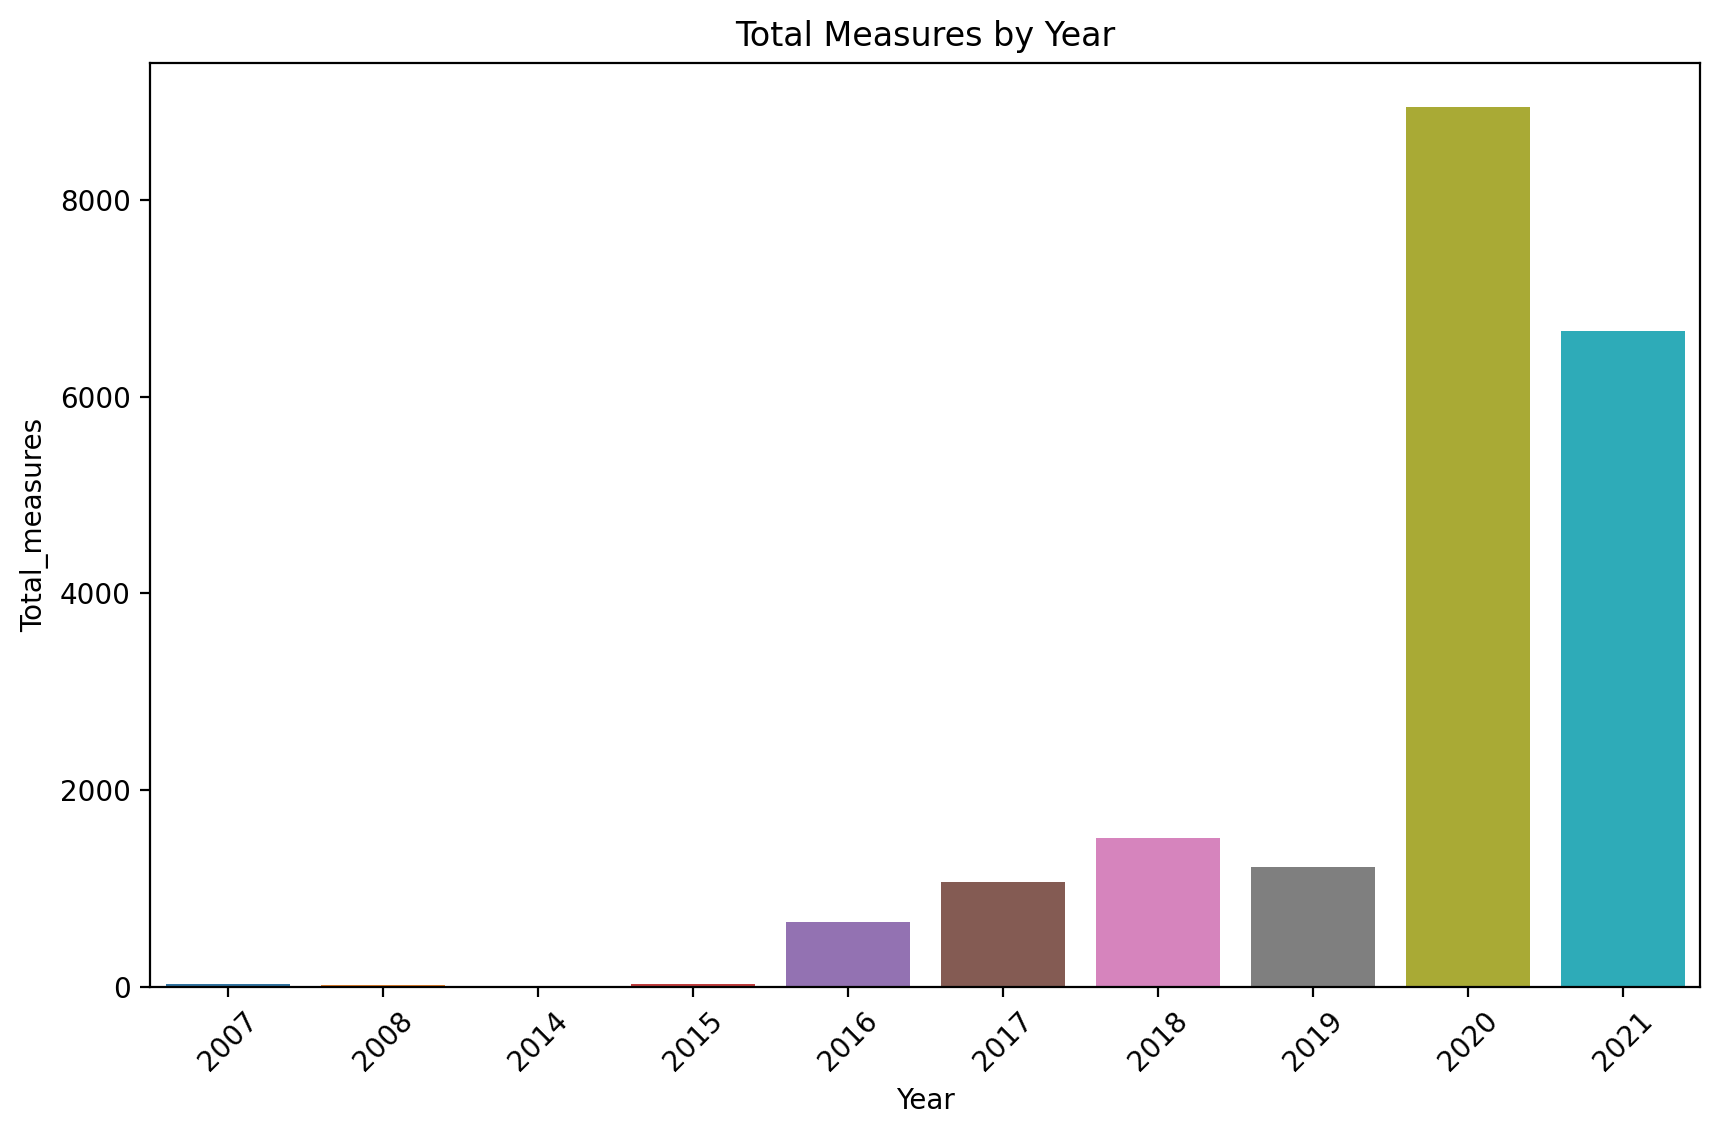

In [5]:

plt.figure(figsize=(10, 6))
sns.barplot(data=df_year_others, x='Year', y='Total_measures', errorbar=None)
plt.title('Total Measures by Year')
plt.xticks(rotation=45)
plt.show()

It can be seen that the number of air quality measurements has increased over time, in 2019 there is a slight decrease (either insufficient data or this is in line with world events (COVID19, decrease in production in all sectors).

But the dramatic fluctuations in the number of measurements from 2020 to 2022 requires further analysis. Let's start with 2022) 

****2022 YEAR**  has an unusually high number of measurements.**

Let's check:
* Did the measurement devices change in 2022 (e.g., more sensors deployed)?
* Was there a new policy or program that increased monitoring in certain locations?
* Is the data skewed because of duplicates or errors in the dataset?

In [6]:
query_source = """
    SELECT 
        EXTRACT(YEAR FROM timestamp) AS year,
        COUNT(*) AS total_source_count
    FROM 
        `bigquery-public-data.openaq.global_air_quality`
    WHERE 
        EXTRACT(YEAR FROM timestamp) IN (2020, 2021, 2022)
    GROUP BY 
        year
    ORDER BY 
        year;
"""
source = client.query(query_source).result().to_dataframe()

source.head(10)

,year,total_source_count
0,2020,17905
1,2021,13344
2,2022,5554361


In [7]:
source['percentage_change'] = source['total_source_count'].pct_change() * 100
source.head()

,year,total_source_count,percentage_change
0,2020,17905,<NA>
1,2021,13344,-25.473331
2,2022,5554361,41524.407974


The number of measurements decreased in 2021 compared to 2020 as the number of sensors decreased by 25.4%.  And for 2022 the number of sensors is unusually high. 
Let's now see if there are duplicates or errors in our dataset. 


In [8]:
query_source_2= """
    SELECT 
        country,
        source_name,
        EXTRACT(YEAR FROM timestamp) AS year,
        COUNT(*) AS source_count
    FROM 
        `bigquery-public-data.openaq.global_air_quality`
    WHERE 
        EXTRACT(YEAR FROM timestamp) BETWEEN 2020 AND 2022
    GROUP BY 
        country, source_name, year
    ORDER BY 
        year, country, source_name;
        """
source_2 = client.query(query_source_2).result().to_dataframe()

source_2.head(10)

,country,source_name,year,source_count
0,AD,EEA Andorra,2020,7
1,AE,AirNow,2020,2
2,AE,StateAir_AbuDhabi,2020,2
3,AE,StateAir_Dubai,2020,2
4,AF,AirNow,2020,1
5,AF,StateAir_Kabul,2020,1
6,AT,EEA Austria,2020,499
7,AU,AirNow,2020,2
8,AU,Australia - ACT,2020,14
9,AU,Australia - New South Wales,2020,158


         year   source_count
count   155.0          155.0
mean   2022.0   35834.587097
std       0.0  137756.757475
min    2022.0            1.0
25%    2022.0          221.5
50%    2022.0          507.0
75%    2022.0        12680.5
max    2022.0      1415933.0
Empty DataFrame
Columns: [country, source_name, year, source_count]
Index: []


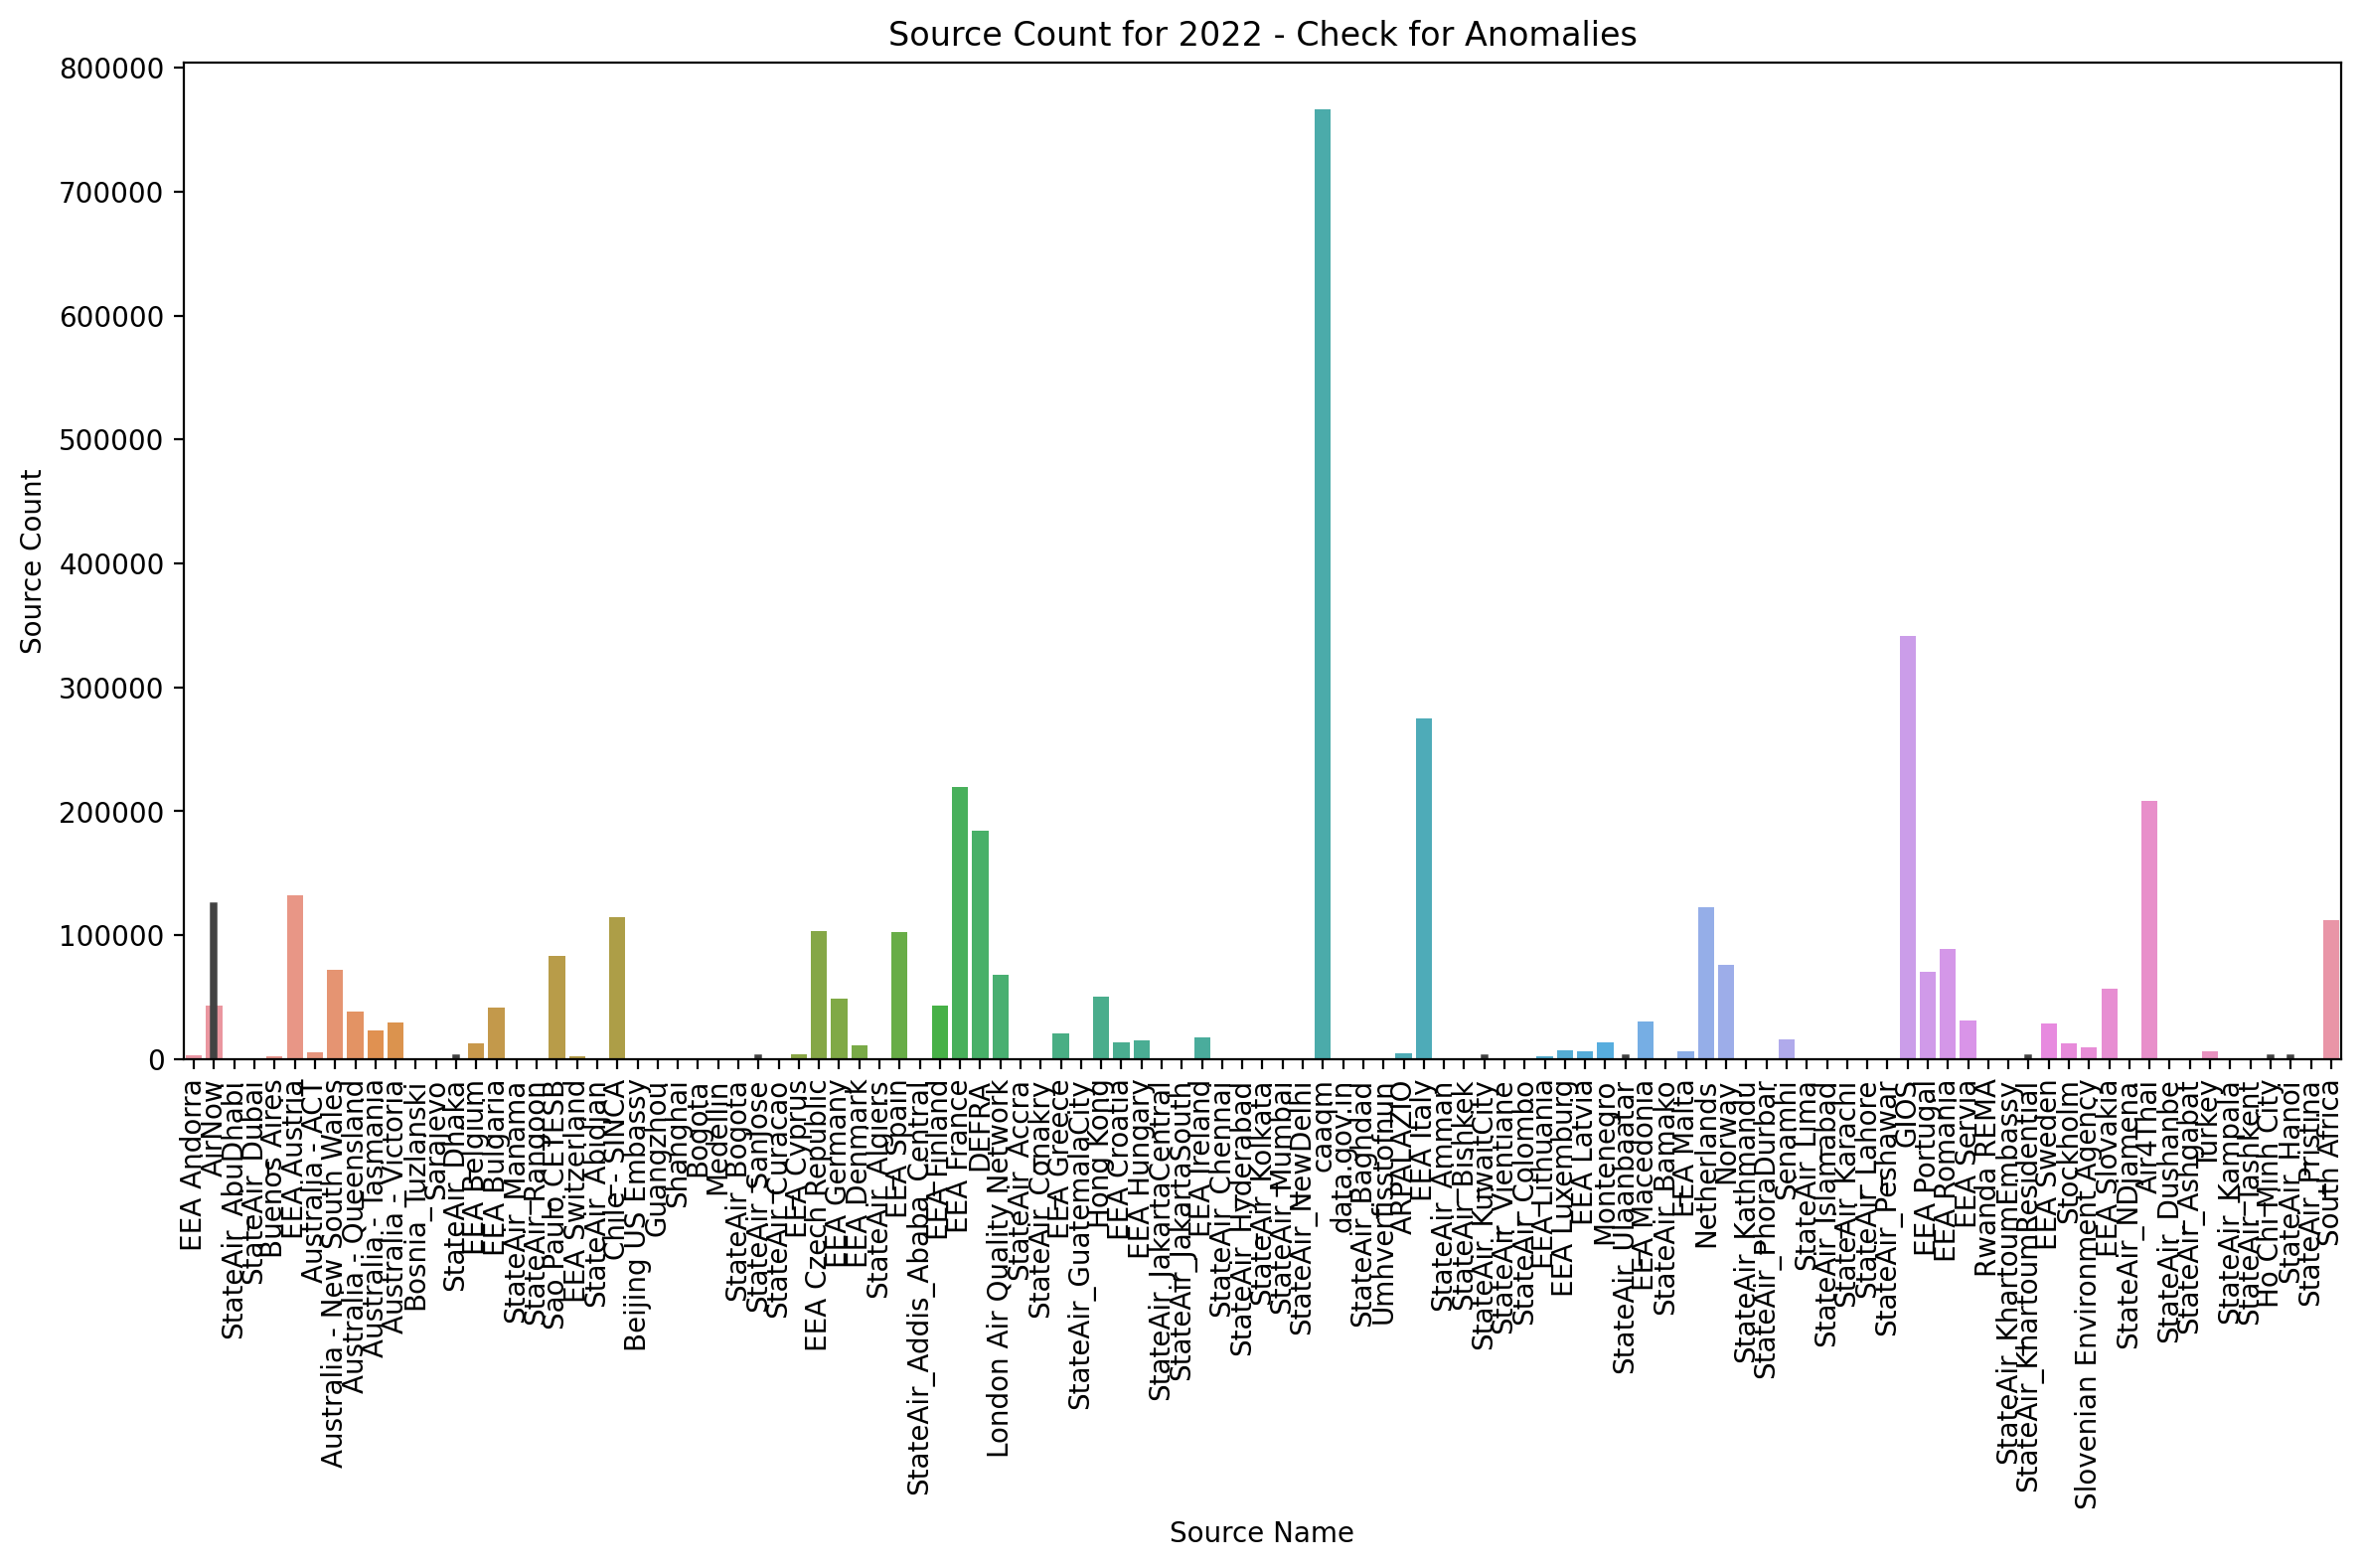

In [9]:
df_2022_source = source_2[source_2['year'] == 2022]

print(df_2022_source.describe())  # Summary statistics

print(df_2022_source[df_2022_source['source_count'] <= 0])  # Negative or zero counts

# 5. Visualize the data for 2020 to identify any visual anomalies
plt.figure(figsize=(12, 8))
sns.barplot(data=df_2022_source, x='source_name', y='source_count')
plt.title('Source Count for 2022 - Check for Anomalies')
plt.xticks(rotation=90)
plt.xlabel('Source Name')
plt.ylabel('Source Count')
plt.tight_layout()
plt.show()

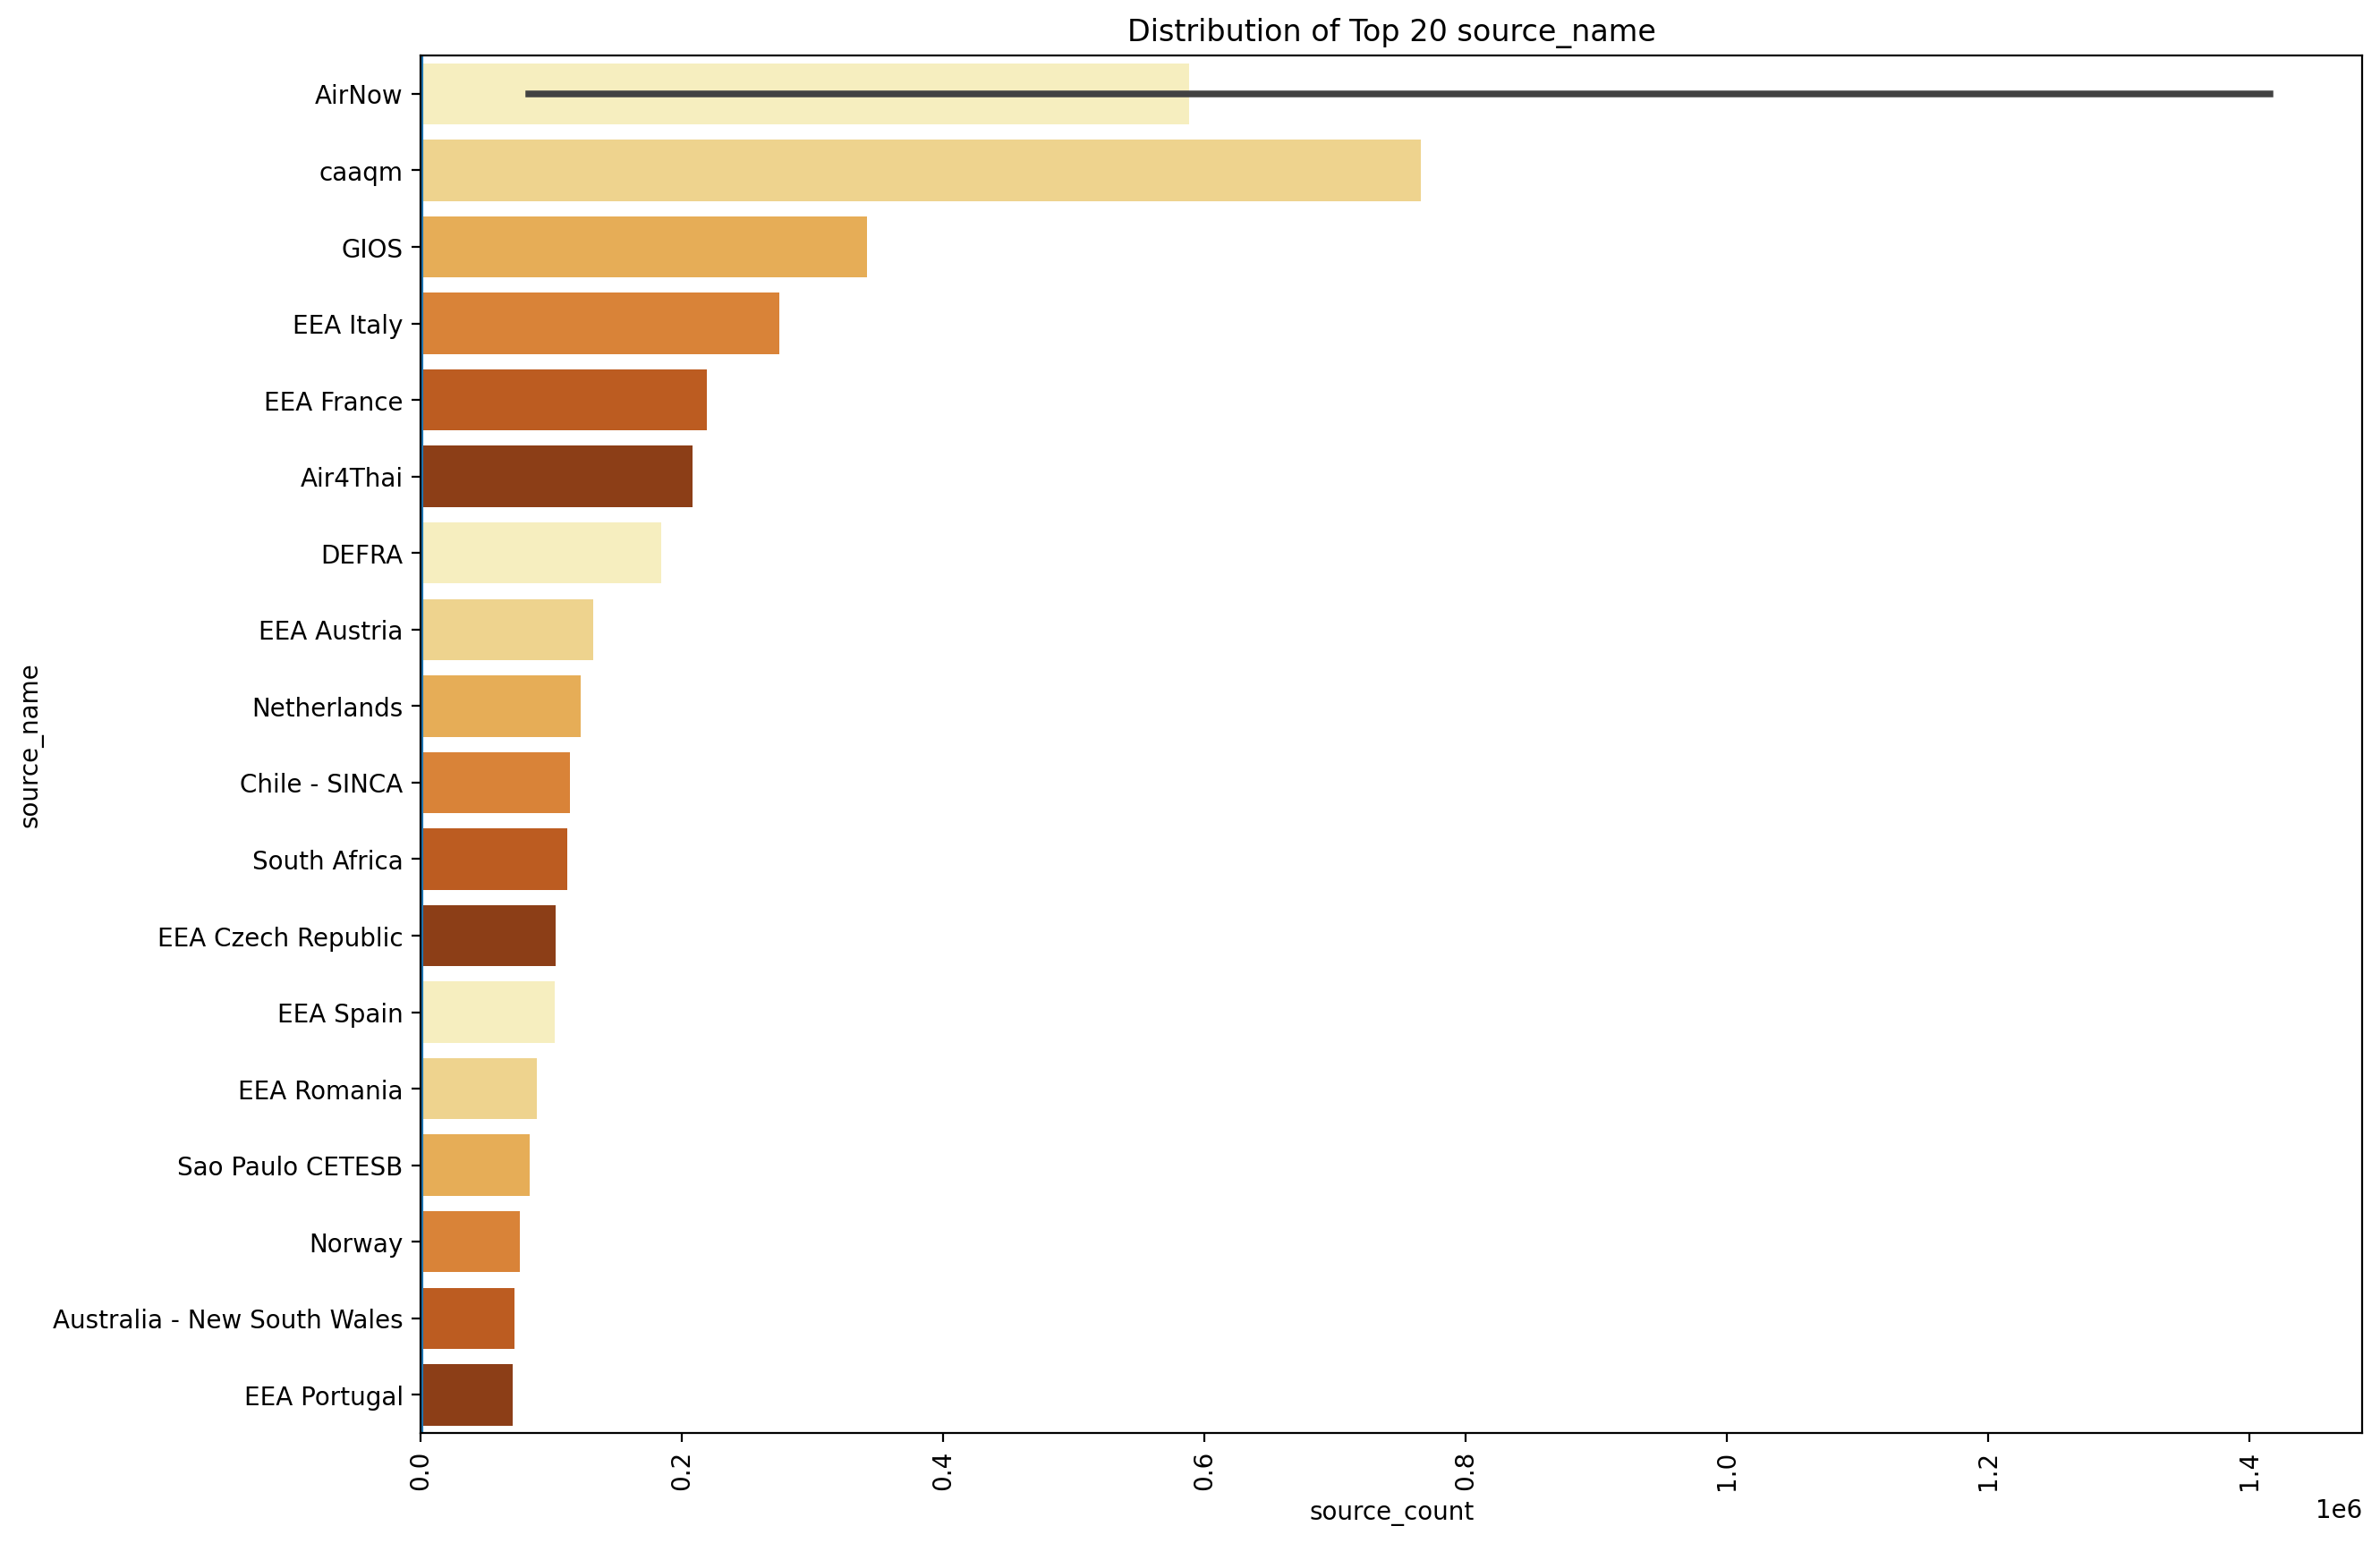

In [10]:
df_2022_source = df_2022_source.sort_values(by="source_count", ascending=False)
plt.figure(figsize=(14,10))
sns.barplot(x=df_2022_source['source_count'][:20], y=df_2022_source['source_name'][:20],palette = sns.color_palette('YlOrBr'))
plt.title('Distribution of Top 20 source_name')
plt.axvline(df_2022_source['source_count'].median())
plt.xticks(rotation=90);

In [13]:
print(source_2[source_2["source_name"] == "caaqm"])

    country source_name  year  source_count
65       IN       caaqm  2020          1351
168      IN       caaqm  2021            57
266      IN       caaqm  2022        766135


In [14]:
print(source_2[source_2["source_name"] == "GIOS"])

    country source_name  year  source_count
101      PL        GIOS  2020            65
181      PL        GIOS  2021            55
313      PL        GIOS  2022        341587


In [15]:
print(source_2[source_2["source_name"] == "AirNow"])
# 

    country source_name  year  source_count
1        AE      AirNow  2020             2
4        AF      AirNow  2020             1
7        AU      AirNow  2020             2
19       BM      AirNow  2020             2
20       CA      AirNow  2020           329
..      ...         ...   ...           ...
336      UG      AirNow  2022            26
338      US      AirNow  2022       1415933
339      UZ      AirNow  2022           383
341      VM      AirNow  2022           198
344      VN      AirNow  2022            11

[81 rows x 4 columns]


I get the strong feeling that the data was either incorrectly collected starting in 2020 or some of the data was lost.
Let's look at the change in air pollutant concentrations using geolocation. 

In [16]:
avg_all_years = """
            SELECT EXTRACT(YEAR FROM timestamp) as `Year`,
                   AVG(value) as `Average`,
                   latitude,
                   longitude,
                   country
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE unit = 'µg/m³'
           AND EXTRACT(YEAR FROM timestamp) >= 2016 # we know the data has been collected steadily since 2016 
        GROUP BY Year, 
                 latitude,
                 longitude,
                 country
        """
avg_all_years_result =client.query(avg_all_years).result().to_dataframe()

avg_all_years_result.head(10)

/usr/local/lib/python3.10/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,Year,Average,latitude,longitude,country
0,2016,1508.0,44.343000,17.268000,BA
1,2016,99.6,1.000000,37.030961,TR
2,2016,316.0,1.000000,43.830000,BA
3,2016,283.0,43.715000,18.036000,BA
4,2016,1872.2,37.311210,27.782932,TR
5,2016,267.0,1.000000,43.848000,BA
6,2016,88.0,1.000000,48.218065,AT
7,2016,435.0,48.278900,14.365858,AT
8,2016,124.5,48.188908,16.301996,AT
9,2016,124.5,1.000000,48.188907,AT


In [18]:
avg_all_years_result.describe()

,Year,Average,latitude,longitude
count,17744.0,17744.000000,17744.000000,17743.000000
mean,2020.432822,56.049804,15.928187,20.055405
std,1.598094,1532.169352,21.265360,46.047446
min,2016.0,-83873.727500,-72.011700,-161.767000
25%,2020.0,9.050000,1.000000,7.896261
50%,2020.0,22.674080,1.000000,33.184200
75%,2022.0,63.500000,39.832387,45.856672
max,2022.0,137639.780000,78.906690,153.402000


In [19]:
avg_all_years_result.head()

,Year,Average,latitude,longitude,country
0,2016,1508.0,44.34300,17.268000,BA
1,2016,99.6,1.00000,37.030961,TR
2,2016,316.0,1.00000,43.830000,BA
3,2016,283.0,43.71500,18.036000,BA
4,2016,1872.2,37.31121,27.782932,TR


The latitude values ( for Austria  as for other countries ) are incorrectly set to 1.000 in the whole dataset , maybe this is a data quality problem or a blank value is used in the dataset. I assume that this pattern will be observed for most countries. 

In [20]:
# Count rows where latitude is 1.0
latitude_one_count = avg_all_years_result[avg_all_years_result['latitude'] == 1.0].shape[0]

total_rows = avg_all_years_result.shape[0]

proportion_latitude_one = latitude_one_count / total_rows

print(f"Proportion of rows where latitude = 1.0: {proportion_latitude_one:.2%}")

Proportion of rows where latitude = 1.0: 57.14%


**To fix it, let's try to compare the name of country locations with the correct coordinates via an additional external API reference.**

 
 So you don't have to collect geodata every time you run the code. I saved them in a separate file (/kaggle/input/geolocated-data-air). 
 Here is the code I used to collect the data. 

In [21]:
geo_location = """
            SELECT EXTRACT(YEAR FROM timestamp) as `Year`,
                   AVG(value) as `Average`,
                   latitude,
                   longitude,
                   city,
                   country
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE unit = 'µg/m³'
        GROUP BY Year, 
                 latitude,
                 longitude,
                 city,
                 country
        """
geo_location =client.query(geo_location).result().to_dataframe()

geo_location.head(10)

/usr/local/lib/python3.10/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,Year,Average,latitude,longitude,city,country
0,2015,213.742000,28.560000,77.094000,Delhi,IN
1,2015,213.742000,0.250000,28.560000,Delhi,IN
2,2007,30.985000,5.567833,-0.204028,Accra,GH
3,2007,75.545000,44.000000,5.534919,Accra,GH
4,2007,41.495000,51.000000,5.640899,Accra,GH
5,2008,43.610000,9.000000,5.583890,Accra,GH
6,2015,790.087500,0.250000,28.678700,Delhi,IN
7,2015,13.230000,24.000000,51.535900,De Rips,NL
8,2015,12.696667,24.000000,51.547500,De Rips,NL
9,2015,36.900000,1.000000,21.048000,Hanoi,VN


In [22]:
import time

# Function to query Nominatim API
def get_geolocation(city, country):
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        'city': city,
        'country': country,
        'format': 'json'
     }
    headers = {
        'User-Agent': ''}
    try:
        response = requests.get(base_url, params=params, headers=headers)
        if response.status_code == 200:
            data = response.json()
            if data:
                # Extract latitude and longitude
                lat = data[0].get('lat')
                lon = data[0].get('lon')
                return lat, lon
            else:
                return None, None
        else:
            print(f"Error: {response.status_code}")
            return None, None
    except Exception as e:
        print(f"Request failed: {e}")
        return None, None



In [ ]:
# Update dataset with correct geolocation
def update_geolocations(df):
    for index, row in df.iterrows():
        city, country = row['city'], row['country']
        print(f"Fetching geolocation for {city}, {country}...")
        lat, lon = get_geolocation(city, country)
        if lat and lon:
            df.loc[index, 'latitude'] = float(lat)
            df.loc[index, 'longitude'] = float(lon)
        time.sleep(1.5)  # Respect the API rate limit
    return df

# Correct geolocations
updated_df = update_geolocations(latitude_incorrect)

updated_df.to_csv('/kaggle/working/geolocated_data.csv', index=False)

In [23]:
geolocation=pd.read_csv("/kaggle/input/geolocation-air-data-match/geolocated_data_2.csv")
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       8693 non-null   int64  
 1   Average    8693 non-null   float64
 2   latitude   8693 non-null   float64
 3   longitude  8693 non-null   float64
 4   city       8654 non-null   object 
 5   country    8693 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 407.6+ KB


In [24]:
geo_location = geo_location[(geo_location['latitude'] != 1.00) & (geo_location['Year'] > 2016)]
final_df = pd.concat([geo_location, geolocation], ignore_index=True)

In [25]:
final_df.head()

,Year,Average,latitude,longitude,city,country
0,2017,178.500000,55.649677,37.546677,Moscow,RU
1,2017,268.266667,55.791862,37.578854,Moscow,RU
2,2017,106.350000,55.456520,36.940840,Moscow,RU
3,2017,13.101875,50.409313,4.452172,Wallonia,BE
4,2017,198.366667,55.670350,37.737823,Moscow,RU


In [26]:
final_df['Average'] = final_df['Average'].replace(0, np.nan)
final_df.dropna(subset=['Average'], inplace=True)
final_df = final_df[final_df['Average']>0]
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15429 entries, 0 to 16057
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       15429 non-null  Int64  
 1   Average    15429 non-null  float64
 2   latitude   15429 non-null  float64
 3   longitude  15428 non-null  float64
 4   city       15390 non-null  object 
 5   country    15429 non-null  object 
dtypes: Int64(1), float64(3), object(2)
memory usage: 858.8+ KB



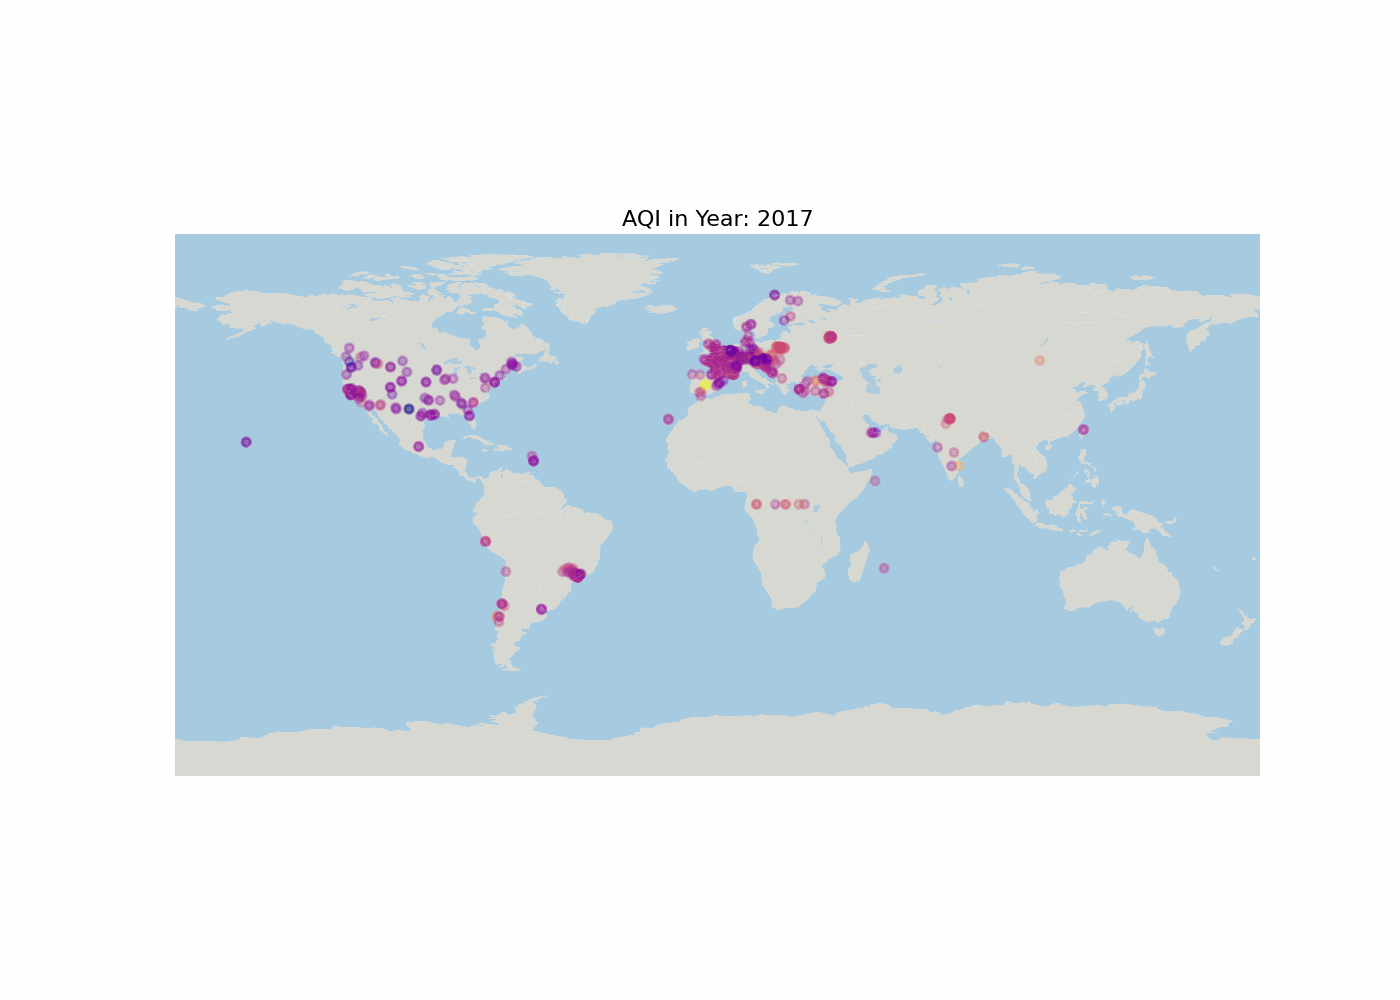

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import animation,rc
import io
import base64
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(14, 10))
plt.style.use('bmh')

def animate(Year):
    ax.clear()  # Clear the axis to prevent overlaps
    ax.set_title(f'AQI in Year: {int(Year)}', fontsize=16)
    ax.axis('off')  # Turn off the axis for a clean map
    
    m4 = Basemap(llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180,urcrnrlon=180,projection='cyl', ax=ax)
    m4.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
    m4.fillcontinents(color='#EEDFCC', alpha=0.7)
    m4.drawcoastlines(linewidth=0.1, color="white")
    m4.shadedrelief()
    
    lat_y = list(final_df[final_df['Year'] == Year]['latitude'])
    lon_y = list(final_df[final_df['Year'] == Year]['longitude'])
    lat,lon = m4(lat_y,lon_y) 
    avg = np.log(final_df[final_df['Year'] == Year]['Average'])
    m4.scatter(lon,lat,c = avg,lw=2, alpha=0.3,cmap='plasma')
   
ani = animation.FuncAnimation(fig,animate,list(final_df['Year'].unique()), interval = 1500)    
ani.save('animation.gif', writer='imagemagick', fps=1)
plt.close(fig)

filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))


From the animation we can see:
- A sharp decline is noticed in 2019, which is in line with world events (COVID19, decrease in production in all sectors)
- Not enough data is collected in 2021 (**for Europe and the Americas, 2021 was lost for data collection**), most data is only displayed for East Asia. **For 2022, on the opposite, data for East Asia have been lost** and data for South America are added.
- However, we see a significant increase in air pollutant levels over the last 3 years.


# Pollution Distribution 

**I propose to take a closer look at the countries of Europe and see who has a higher value for air pollutant concentrations for 2022 and then do a more thorough analysis.**

In [27]:
def classify_region(lat, lon):  
    if 35 <= lat <= 71 and -11 <= lon <= 29:
        return 'Europe'
    elif 4 <= lat <= 50 and 100 <= lon <= 142:
        return 'East Asia'
    elif 25 <= lat <= 50 and -130 <= lon <= -67:
        return 'USA' 
    else:
        return 'Other'

final_df['Region'] = final_df.apply(lambda row: classify_region(row['latitude'], row['longitude']), axis=1)

In [28]:
df_2022 = final_df[(final_df["Year"] == 2022) & (final_df["Region"] == "Europe")]
df_2020 = final_df[(final_df["Year"] == 2020) & (final_df["Region"] == "Europe")]
df_2years = pd.concat([df_2022,df_2020], ignore_index=True)
grouped = df_2years.groupby(['Year', 'Region'])['Average'].mean().reset_index()
grouped.head()

,Year,Region,Average
0,2020,Europe,42.373844
1,2022,Europe,44.810163


In [29]:
diff1 = df_2022['country'].isin(df_2020['country'])  
diff2 = df_2020['country'].isin(df_2022['country'])  
df_diff1 = df_2022[~diff1] 

print("Country in 2022 but not in 2020:")
print(df_diff1)

Country in 2022 but not in 2020:
       Year      Average   latitude  longitude          city country  Region
11436  2022    53.135596  42.773939  18.948810        Nikšić      ME  Europe
11437  2022    58.728507  43.356561  19.358472      Pljevlja      ME  Europe
11439  2022    67.979536  42.424920  18.771333         Kotor      ME  Europe
11446  2022   287.018696  42.441524  19.262108     Podgorica      ME  Europe
11448  2022    66.552044  43.034160  19.747356  Bijelo Polje      ME  Europe
11456  2022   358.181000  41.006381  28.975872      İstanbul      TR  Europe
11461  2022   719.968542  41.006381  28.975872      İstanbul      TR  Europe
11463  2022    47.636750  38.612579  27.433397        Manisa      TR  Europe
11467  2022  1200.926042  41.006381  28.975872      İstanbul      TR  Europe
11485  2022   111.074694  38.423743  27.142802         İzmir      TR  Europe
11491  2022   523.092969  41.006381  28.975872      İstanbul      TR  Europe
11498  2022   337.527969  41.006381  28.975

**Turkey(TR)** - is a unique country, part of which belongs to Europe and the other part to Asia. But still, most of the country's area, namely 97%, is in Asia, and only 3% (southeast of the Balkan Peninsula) belongs to the European part. Most likely the data from this area went to 2022.

However, there is no data on air pollutant concentrations for 2020. 
I will exclude Turkey's data from the dataset so that only European countries can be considered. 

In [30]:
df_2022 = df_2022[df_2022["country"]!= 'TR']
df_2years = pd.concat([df_2022,df_2020], ignore_index=True)
grouped = df_2years.groupby(['Year', 'Region'])['Average'].mean().reset_index()
grouped.head()

,Year,Region,Average
0,2020,Europe,42.373844
1,2022,Europe,43.333799


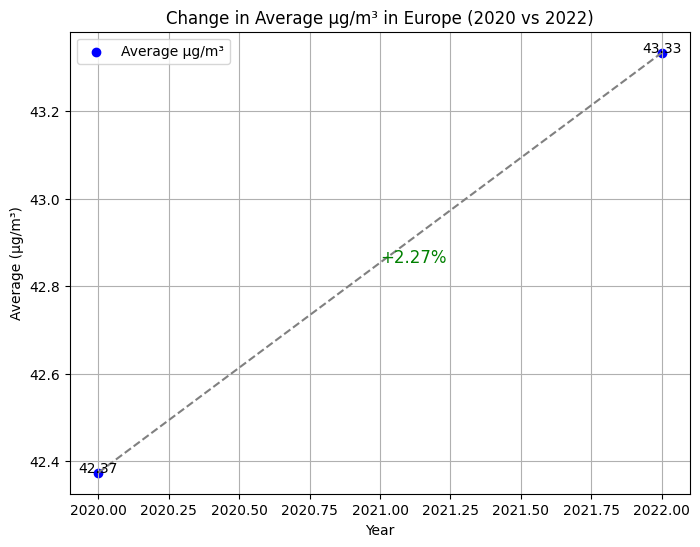

In [31]:
# Calculate percentage increase
percentage_increase = ((grouped.loc[1, 'Average'] - grouped.loc[0, 'Average']) / grouped.loc[0, 'Average']) * 100

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(grouped['Year'], grouped['Average'], color='blue', label='Average µg/m³')
plt.plot(grouped['Year'], grouped['Average'], color='gray', linestyle='--')

# Add annotations
for i in range(len(grouped)):
    plt.text(grouped['Year'][i], grouped['Average'][i], f"{grouped['Average'][i]:.2f}", ha='center', fontsize=10)

plt.text(2021, (grouped['Average'].mean()), f"+{percentage_increase:.2f}%", fontsize=12, color='green')

# Labels and title
plt.xlabel('Year')
plt.ylabel('Average (µg/m³)')
plt.title('Change in Average µg/m³ in Europe (2020 vs 2022)')
plt.grid(True)
plt.legend()
plt.show()

As we can see from the graph, the concentration of pollutants increased by 2.27% in two years in Europe. 
I attribute it to environmental directives:
Directive 2008/50/EC on Ambient Air Quality and Cleaner Air for Europe

The 8th Environment Action Program till 2030 [source](https://wecoop.eu/regional-knowledge-centre/eu-policies-regulations/)

Aiming to set the direction of European environmental policy for the period up to 2030, is to accelerate the transition to a climate-neutral, resource-efficient, regenerative economy in which more resources are returned to the planet than are consumed. 
Two of the six priorities enshrined in the document are as follows:
 - aiming for zero pollution, including in relation to air, water and soil conditions, and protecting the health and well-being of Europe's population;
 - protecting, conserving and restoring biodiversity and enhancing natural capital (especially air, water, soil and forests, freshwater, wetland and marine ecosystems);

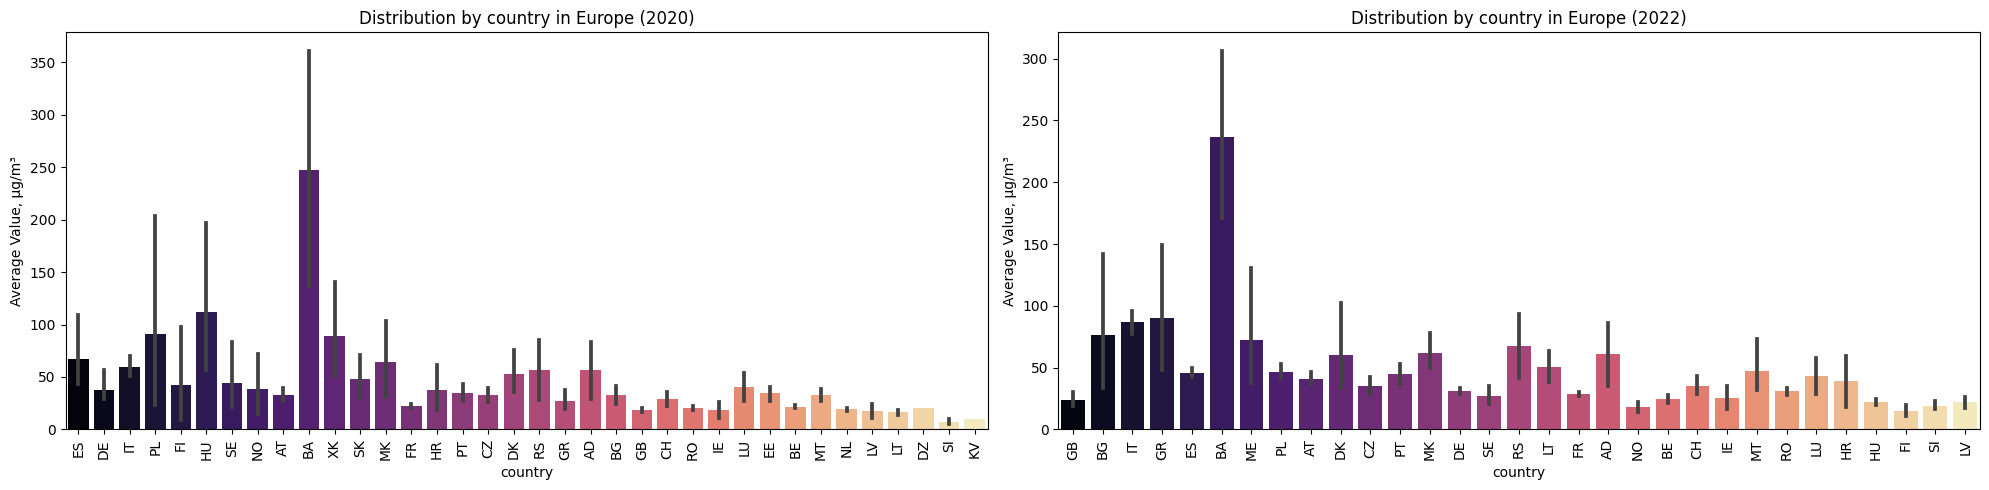

In [32]:
df_2020_sorted = df_2020.sort_values(by="Average", ascending=False)
df_2022_sorted = df_2022.sort_values(by="Average", ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Bar plot for 2020
sns.barplot(data=df_2020_sorted, y="Average", x="country", palette='magma', ax=axes[0])
axes[0].set_ylabel('Average Value, µg/m³')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_title('Distribution by country in Europe (2020)')

# Bar plot for 2022
sns.barplot(data=df_2022_sorted, y="Average", x="country", palette='magma', ax=axes[1])
axes[1].set_ylabel('Average Value, µg/m³')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_title('Distribution by country in Europe (2022)')

# Display the plots
plt.tight_layout()
plt.show()


In [33]:
top_5_countries_2020 = df_2020.groupby('country')['Average'].mean().sort_values(ascending=False).head(5)
print(top_5_countries_2020)

top_5_countries_2022 = df_2022.groupby('country')['Average'].mean().sort_values(ascending=False).head(5)
print(top_5_countries_2022)


country
BA    246.866667
HU    111.679393
PL     91.153727
XK     88.973078
ES     67.199884
Name: Average, dtype: float64
country
BA    236.989000
GR     90.033818
IT     86.746528
BG     76.046745
ME     72.620417
Name: Average, dtype: float64


**top_5_countries_2020:** 
BA: Bosnia and Herzegovina,
HU: Hungary,
PL: Poland,
XK: Kosovo,
ES: Spain.

**top_5_countries_2022:**
BA: Bosnia and Herzegovina,
GR: Greece,
IT: Italy,
BG: Bulgaria,
ME: Montenegro.

In [34]:
# Example of filtered data
ba_2022 = df_2022[df_2022['country'] == 'BA']
ba_2020 = df_2020[df_2020['country'] == 'BA']
# Assuming 'Average' column holds the pollutant concentration values
average_2020 = ba_2020['Average'].values[0]  
average_2022 = ba_2022['Average'].values[0]  
percentage_BA = ((average_2022 - average_2020) / average_2020) * 100
print(f"Percentage change in air pollutant concentration in Bosnia and Herzegovina (BA) from 2020 to 2022: {percentage_BA:.2f}%")

Percentage change in air pollutant concentration in Bosnia and Herzegovina (BA) from 2020 to 2022: -12.43%


**Bosnia and Herzegovina (BA) - has a high average air pollutant concentration index (2020 vs. 2022), but air pollutant concentrations have decreased by 12,43%**

In [46]:
pollutant_query_BA = """
    SELECT EXTRACT(Month FROM timestamp) as `Month`,
           FORMAT_TIMESTAMP('%Y-%m-%d', timestamp) AS formatted_date,
           country, 
           pollutant,
           value 
    FROM `bigquery-public-data.openaq.global_air_quality`
    WHERE
      country = "BA"
      AND value > 0
      AND EXTRACT(YEAR FROM timestamp) = 2022
      AND unit = 'µg/m³'
    GROUP BY country, pollutant, `Month`, formatted_date, value
    ORDER BY value ASC
        """

pollutant_ba = client.query(pollutant_query_BA).result().to_dataframe()
pollutant_ba.head()

/usr/local/lib/python3.10/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,Month,formatted_date,country,pollutant,value
0,1,2022-01-12,BA,pm25,5.6
1,1,2022-01-12,BA,pm25,6.3
2,1,2022-01-12,BA,so2,11.3
3,1,2022-01-12,BA,no2,12.7
4,1,2022-01-12,BA,no2,16.8


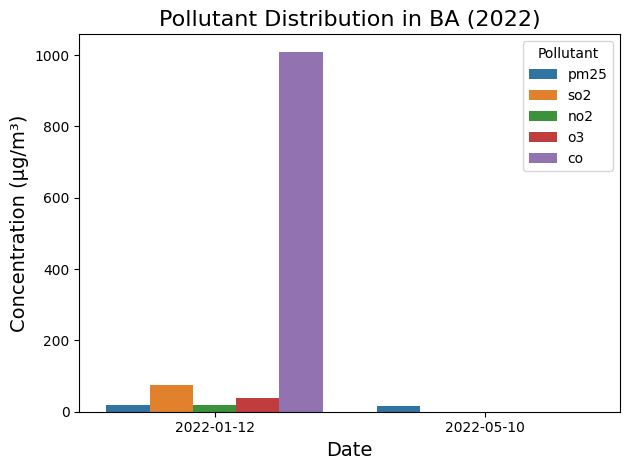

In [39]:
sns.barplot(data=pollutant_ba, x="formatted_date", y="value", hue = "pollutant", errorbar=None)
plt.legend(title="Pollutant", loc='upper right')

plt.title('Pollutant Distribution in BA (2022)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Concentration (µg/m³)', fontsize=14)

plt.tight_layout()
plt.show()

The bigquery-public-data.openaq.global_air_quality table contains incomplete or inconsistent records for certain countries, such as Bosnia and Herzegovina (BA). For BA, there are only two dates of measurements available, which significantly limits the reliability of any trend analysis or comparisons.

**The OpenAQ platform** relies on publicly available air quality monitoring stations. Some regions or countries might not have robust monitoring infrastructure or may not report data consistently.


# Focus on GIOS Data

We see that for 2022 the main source of information on pollutant concentrations is **GIOS**. 
GIOS (Chief Inspectorate of Environmental Protection in Poland) is a reliable and comprehensive source for pollutant concentration data in 2022, with a substantial number of records (source_count = 341,587)

[source: GIOŚ INSPIRE](https://inspire.gios.gov.pl/imap/#gpmap=gpmapAIR)

# Pollutant Analysis

In [53]:
pollutant_query_PL = """
    SELECT EXTRACT(Month FROM timestamp) as `Month`,
           FORMAT_TIMESTAMP('%Y-%m-%d', timestamp) AS formatted_date,
           country, 
           pollutant,
           value 
    FROM `bigquery-public-data.openaq.global_air_quality`
    WHERE
      country = "PL"
      AND pollutant != "bc"
      AND value > 0
      AND EXTRACT(YEAR FROM timestamp) = 2022
      AND unit = 'µg/m³'
    GROUP BY country, pollutant, `Month`, formatted_date, value
    ORDER BY value ASC
        """

pol = client.query(pollutant_query_PL).result().to_dataframe()
pol.head(10)

,Month,formatted_date,country,pollutant,value
0,4,2022-04-27,PL,so2,0.00003
1,5,2022-05-26,PL,so2,0.00088
2,5,2022-05-26,PL,so2,0.00171
3,5,2022-05-06,PL,o3,0.00306
4,5,2022-05-07,PL,o3,0.00389
5,5,2022-05-21,PL,no2,0.00584
6,5,2022-05-18,PL,pm25,0.00709
7,4,2022-04-29,PL,so2,0.00733
8,3,2022-03-31,PL,so2,0.00918
9,4,2022-04-27,PL,so2,0.00928


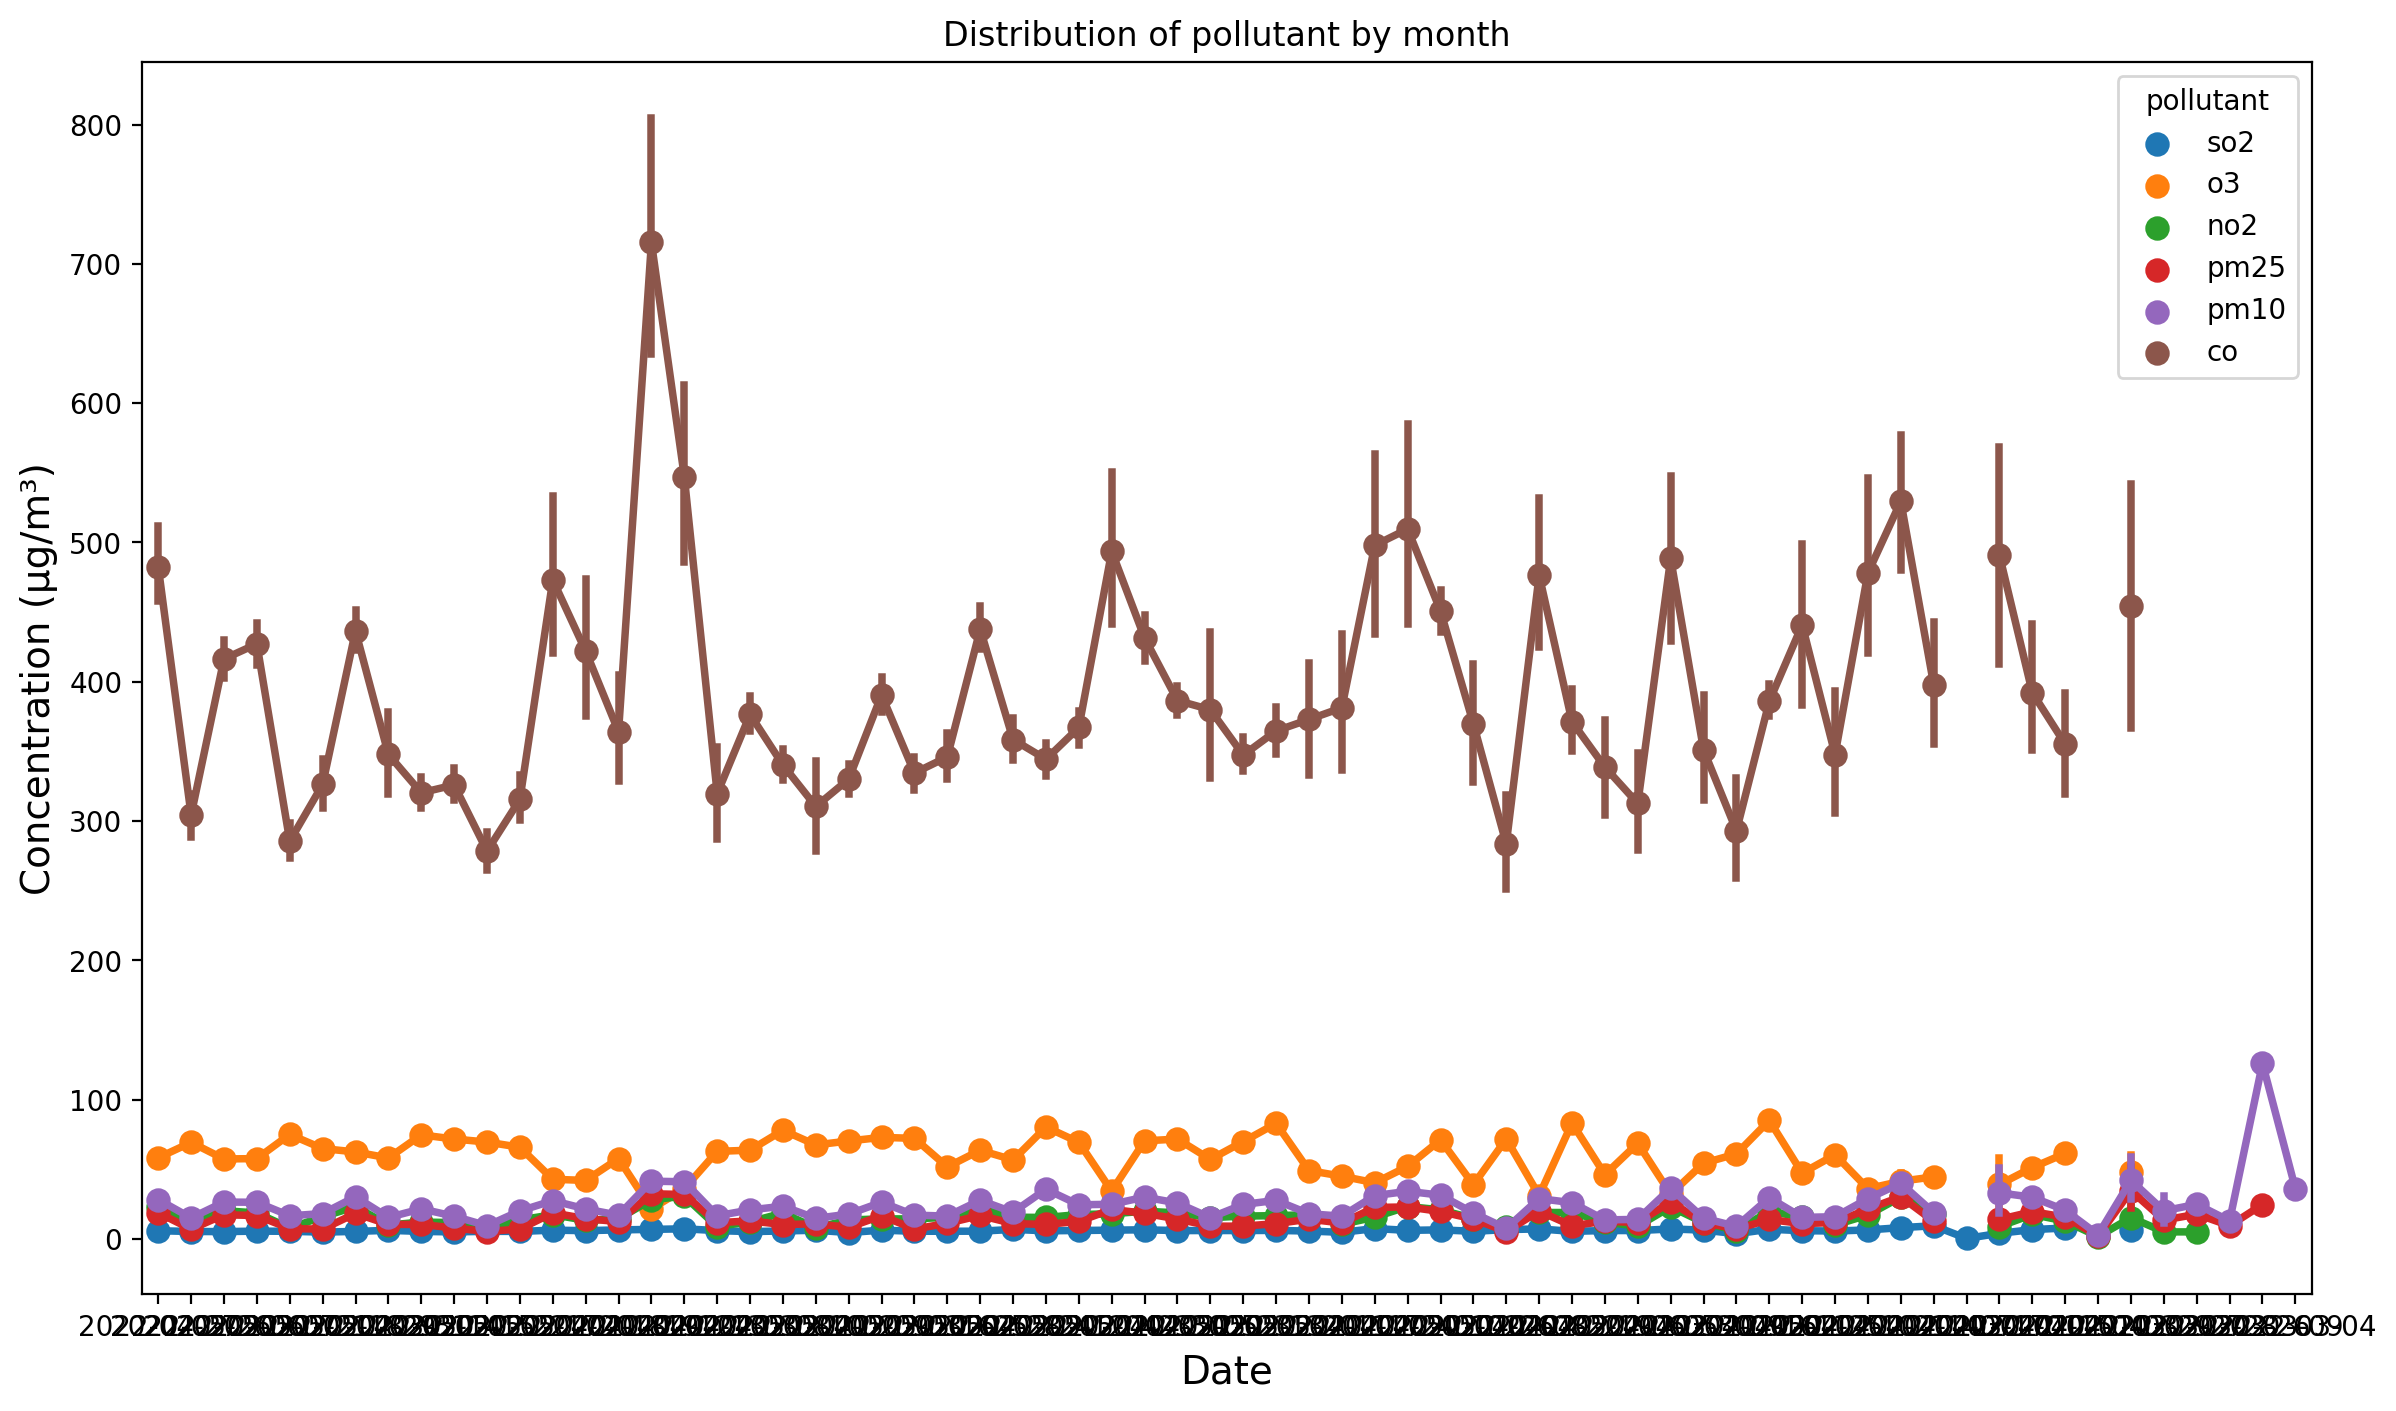

In [61]:
plt.figure(figsize=(14,8))
sns.pointplot(data=pol,x=pol['formatted_date'],y=pol['value'],hue = pol['pollutant'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Concentration (µg/m³)', fontsize=14)
plt.title('Distribution of pollutant by month');

In [65]:
pol.describe()

,Month,value
count,274100.0,274100.000000
mean,4.765447,64.196207
std,0.441497,138.598041
min,1.0,0.000030
25%,5.0,8.129990
50%,5.0,18.343000
75%,5.0,50.483425
max,5.0,5695.180000


**Again, we see that the data was not collected for the whole year, but only for the first 5 months. We cannot rely on this dataset to draw conclusions or make any forecasts.**

# Conclusion

The data in the OpenAQ dataset was not collected for the entire year, but only for certain months (e.g., the first five months of 2022). This incomplete coverage makes the dataset unsuitable for reliable air pollution forecasting. Significant gaps in data collection and consistency are evident, especially in regions such as Europe, South America, and parts of East Asia, posing significant challenges for forecasting.
The short time horizon of available data, especially the limited coverage in 2021, hinders the ability to establish reliable seasonal trends or long-term patterns needed for accurate air pollution forecasting models. In addition, the lack of consistent reporting across years and regions severely limits the use of this dataset for training machine learning or statistical forecasting models.
GIOS (Chief Inspectorate of Environmental Protection in Poland) was identified as a primary and reliable source of pollutant concentration data in 2022, contributing a significant volume of records. However, the reliance on a single source limits broader geographic analysis and cross-region comparisons.
Overall, the dataset's fragmented nature, inconsistent coverage, and short time span render it unreliable for deriving comprehensive insights or building predictive models for air pollution trends. A more robust and consistently collected dataset is necessary to ensure the accuracy and reliability of forecasting efforts.